In [1]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
from mesa.space import ContinuousSpace, HexGrid
from itertools import product
from mesa.visualization.modules import CanvasGrid
from mesa.visualization.ModularVisualization import ModularServer
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd

In [3]:
from enum import Enum

## COVID - 19 Agent Based Model
Instead of creating a mathmatcial model, I attemped to create an agent based model.

Whilst it makes some very basic assumptions (people wander about randomly, increased hygiene reduces tranmission radius, 'social distancing' makes people move around slower), it replicates a very similar curve (and curve mitigation) that purely mathmatical SIR models show.

It also has the bonus of creating an animated version, watching all the little people jitter around ;)


## Create The Agent

In [4]:
class State(Enum):
    S = 0
    I = 1
    R = 2
    
def number_state(model, state):
    width_range = range(0, model.grid.width)
    height_range = range(0, model.grid.height)
    cells = product(width_range, height_range)
    return sum([1 for a in model.grid.get_cell_list_contents(cells) if a.state is state])

def number_s(model):
    return number_state(model, State.S)

def number_i(model):
    return number_state(model, State.I)

def number_r(model):
    return number_state(model, State.R)

def r_zero(model):
    infect_number = sum([agent.number_infected for agent in model.schedule.agents]);
    try:
        return infect_number / number_i(model)
    except ZeroDivisionError:
        return 0


class PersonAgent(Agent):
    def __init__(
        self,
        unique_id,
        model,
        initial_state,
        virus_spread_chance,
        symptomatic_chance,
        incubation_period,
        infection_period,
        movement_speed,
        infection_radius,
        distancing=False,
        recovery_rate=.9,
        jitter=True
    ):
        
        super().__init__(unique_id, model)

        self.state = initial_state
        self.virus_spread_chance = virus_spread_chance
        self.symptomatic_chance = symptomatic_chance
        self.incubation_period = incubation_period
        self.infection_period = infection_period
        self.movement_speed = movement_speed
        self.infection_radius = infection_radius
        self.number_infected = 0
        self.recovery_rate = recovery_rate
        self.symptomatic = False
        self.distancing = distancing
        self.days_infected = 0
        self.previous_pos = None
        self.jitter = jitter
    
    def infect_neighbors(self):
        
        neighbors = self.model.grid.get_neighbors(self.pos, include_center=False, radius=self.infection_radius)
        
        susceptible_neighbors = [agent for agent in neighbors if agent.state is State.S]
        
        for agent in susceptible_neighbors:
            # Infect new PersonAgents
            if self.random.random() < self.virus_spread_chance:
                agent.state = State.I
                self.number_infected += 1
        
    
    def move(self):
        # See if the person is going to move
        if self.random.random() < self.movement_speed:
            # Get the local neighbors
            neighborhood = self.model.grid.get_neighborhood(self.pos, 1, False)
            # Get the empty cells
            empty_cells = [cell for cell in neighborhood if self.model.grid.is_cell_empty(cell)]
            
            if self.jitter:
                if self.previous_pos:
                    if self.previous_pos in empty_cells:
                        empty_cells.remove(self.previous_pos)
            
            # make sure the are empty cells, if not ignore
            if len(empty_cells) > 0:
                
                self.previous_pos = self.pos
                
                new_position = self.random.choice(empty_cells)
            
                self.model.grid.move_agent(self, new_position)
    
    def try_to_recover(self):
        
        if self.days_infected > self.infection_period:
            
            if self.random.random() < self.recovery_rate:
                self.state = State.R
                return
        else:
            self.days_infected += 1
            
    def step(self):
        self.move()
        if self.state == State.I:
            self.infect_neighbors()
            self.try_to_recover()
    
    # TODO self isolate function
    # TODO social distancing function

## Create The Model

In [5]:
class COVIDModel(Model):
    
    def __init__(
        self,
        width=100,
        height=100,
        N=43,
        initial_outbreak_size=1,
        virus_spread_chance=0.1,
        symptomatic_chance=1,
        incubation_period=140,
        infection_period=280,
        movement_speed=1,
        infection_radius=5,
        distancing=False,
        recovery_rate=.9
    ):
        self.num_people = N
        self.grid = HexGrid(width, height, False)
        self.schedule = RandomActivation(self)
        self.running = True
        # Create agents
        for i in range(self.num_people):
            a = PersonAgent(
                i,
                self,
                State.S,
                virus_spread_chance=virus_spread_chance,
                symptomatic_chance=symptomatic_chance,
                incubation_period=incubation_period,
                infection_period=infection_period,
                movement_speed=movement_speed,
                infection_radius=infection_radius,
                distancing=distancing,
                recovery_rate=recovery_rate
            )
            self.schedule.add(a)
            self.grid.place_agent(a, self.grid.find_empty())
            
        
        self.datacollector = DataCollector({
            'Infected': number_i,
            'Susceptible': number_s,
            'Removed': number_r,
            'R0': r_zero,
        })
        
        # Infect some
        infected_agents = self.random.sample(self.schedule.agents, initial_outbreak_size)
        for agent in infected_agents:
            agent.state = State.I
        
        self.datacollector.collect(self)
        
    def step(self):
        self.schedule.step()
        self.datacollector.collect(self)
    
    def run_model(self, n):
        for i in range(n):
            self.step()
            if number_i(self)==0:
                return

### Initiate The Different Models

In [6]:
covid = COVIDModel(initial_outbreak_size=2, N=100, virus_spread_chance=.8,
                  movement_speed=1, infection_radius=5)

In [8]:
covid_slow = COVIDModel(initial_outbreak_size=2, N=100, virus_spread_chance=.8,
                  movement_speed=0.3, infection_radius=5)

covid_clean = COVIDModel(initial_outbreak_size=2, N=100, virus_spread_chance=.8,
                  movement_speed=1, infection_radius=3)

covid_clean_slow = COVIDModel(initial_outbreak_size=2, N=100, virus_spread_chance=.8,
                  movement_speed=0.3, infection_radius=3)

### Run each model for approximately 75 days

In [9]:
covid.run_model(1500)
covid_slow.run_model(1500)
covid_clean.run_model(1500)
covid_clean_slow.run_model(1500)

In [10]:
df = covid.datacollector.get_model_vars_dataframe()
df_slow = covid_slow.datacollector.get_model_vars_dataframe()
df_clean = covid_clean.datacollector.get_model_vars_dataframe()
df_clean_slow = covid_clean_slow.datacollector.get_model_vars_dataframe()

In [33]:
sns.set_context('paper')
sns.set_style('white')

Text(1100, 30, 'Herd immunity achieved by day 50\nApproximately 60% infected and virus can no longer reproduce')

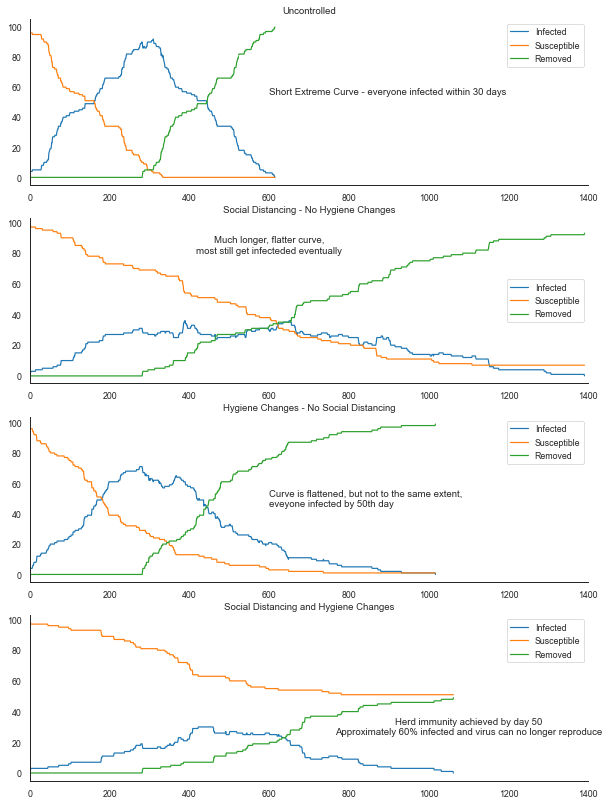

In [78]:
fig, axes = plt.subplots(4, 1,figsize=(10,14))

titles = [
    'Uncontrolled',
    'Social Distancing - No Hygiene Changes',
    'Hygiene Changes - No Social Distancing',
    'Social Distancing and Hygiene Changes'
]

axes = axes.ravel()

for i, ax in enumerate(axes):
    sns.despine(top=True)
    ax.set_xlim([0, 1400])
    ax.set_title(titles[i])


df[['Infected', 'Susceptible', 'Removed']].plot(ax = axes[0])
df_slow[['Infected', 'Susceptible', 'Removed']].plot(ax=axes[1])
df_clean[['Infected', 'Susceptible', 'Removed']].plot(ax=axes[2])
df_clean_slow[['Infected', 'Susceptible', 'Removed']].plot(ax=axes[3])

axes[0].annotate(
    s='Short Extreme Curve - everyone infected within 30 days',
    xy=(300, 95), xytext=(600, 60), arrowprops=arrowprops,
    xycoords='data',horizontalalignment='left', verticalalignment='top',
)


axes[1].annotate(
    s='Much longer, flatter curve,\nmost still get infecteded eventually',
    xy=(600, 80), horizontalalignment='center'
)

axes[2].annotate(
    s='Curve is flattened, but not to the same extent,\neveyone infected by 50th day',
    xy=(600, 50), verticalalignment='center',
)

axes[3].annotate(
    s='Herd immunity achieved by day 50\nApproximately 60% infected and virus can no longer reproduce', xy=(1100,30), 
    verticalalignment='center', horizontalalignment='center'
)

In [15]:
df.to_csv('original.csv')
df_slow.to_csv('slow.csv')
df_clean.to_csv('clean.csv')
df_clean_slow.to_csv('clean_slow.csv')

### Animating It

In [16]:
from mesa.visualization.modules import CanvasHexGrid

In [17]:
def agent_portrayal(agent):
    portrayal = {
        'Shape': 'hex',
        'Color': 'blue',
        'Filled': 'true',
        'Layer': 0,
        'r': 1,
        'x': agent.pos[0],
        'y': agent.pos[1],
        
    }
    
    if agent.state is State.S:
        portrayal['Color'] = 'blue'
    elif agent.state is State.I:
        portrayal['Color'] = 'red'
    else:
        portrayal['Color'] = 'grey'
    return portrayal

In [18]:
canvas = CanvasHexGrid(agent_portrayal, 60, 60, 500, 500)

In [176]:
server = ModularServer(
    COVIDModel,
    [canvas],
    'COVID Model',
    {
        'N': 60,
        'width':60,
        'height':60, 
        'virus_spread_chance': 0.8, 
        'infection_radius': 5,
        'movement_speed': 1,
        'initial_outbreak_size': 2,
    }
)

server.port = 8531
server.launch()

Interface starting at http://127.0.0.1:8531


RuntimeError: This event loop is already running

Socket opened!
{"type":"get_params"}
{"type":"reset"}
{"type":"get_step","step":1}
{"type":"get_step","step":2}
{"type":"get_step","step":3}
{"type":"get_step","step":4}
{"type":"get_step","step":5}
{"type":"get_step","step":6}
{"type":"get_step","step":7}
{"type":"get_step","step":8}
{"type":"get_step","step":9}
{"type":"get_step","step":10}
{"type":"get_step","step":11}
{"type":"get_step","step":12}
{"type":"get_step","step":13}
{"type":"get_step","step":14}
{"type":"get_step","step":15}
{"type":"get_step","step":16}
{"type":"get_step","step":17}
{"type":"get_step","step":18}
{"type":"get_step","step":19}
{"type":"get_step","step":20}
{"type":"get_step","step":21}
{"type":"get_step","step":22}
{"type":"get_step","step":23}
{"type":"get_step","step":24}
{"type":"get_step","step":25}
{"type":"get_step","step":26}
{"type":"get_step","step":27}
{"type":"get_step","step":28}
{"type":"get_step","step":29}
{"type":"get_step","step":30}
{"type":"get_step","step":31}
{"type":"get_step","step"

{"type":"get_step","step":268}
{"type":"get_step","step":269}
{"type":"get_step","step":270}
{"type":"get_step","step":271}
{"type":"get_step","step":272}
{"type":"get_step","step":273}
{"type":"get_step","step":274}
{"type":"get_step","step":275}
{"type":"get_step","step":276}
{"type":"get_step","step":277}
{"type":"get_step","step":278}
{"type":"get_step","step":279}
{"type":"get_step","step":280}
{"type":"get_step","step":281}
{"type":"get_step","step":282}
{"type":"get_step","step":283}
{"type":"get_step","step":284}
{"type":"get_step","step":285}
{"type":"get_step","step":286}
{"type":"get_step","step":287}
{"type":"get_step","step":288}
{"type":"get_step","step":289}
{"type":"get_step","step":290}
{"type":"get_step","step":291}
{"type":"get_step","step":292}
{"type":"get_step","step":293}
{"type":"get_step","step":294}
{"type":"get_step","step":295}
{"type":"get_step","step":296}
{"type":"get_step","step":297}
{"type":"get_step","step":298}
{"type":"get_step","step":299}
{"type":

{"type":"get_step","step":537}
{"type":"get_step","step":538}
{"type":"get_step","step":539}
{"type":"get_step","step":540}
{"type":"get_step","step":541}
{"type":"get_step","step":542}
{"type":"get_step","step":543}
{"type":"get_step","step":544}
{"type":"get_step","step":545}
{"type":"get_step","step":546}
{"type":"get_step","step":547}
{"type":"get_step","step":548}
{"type":"get_step","step":549}
{"type":"get_step","step":550}
{"type":"get_step","step":551}
{"type":"get_step","step":552}
{"type":"get_step","step":553}
{"type":"get_step","step":554}
{"type":"get_step","step":555}
{"type":"get_step","step":556}
{"type":"get_step","step":557}
{"type":"get_step","step":558}
{"type":"get_step","step":559}
{"type":"get_step","step":560}
{"type":"get_step","step":561}
{"type":"get_step","step":562}
{"type":"get_step","step":563}
{"type":"get_step","step":564}
{"type":"get_step","step":565}
{"type":"get_step","step":566}
{"type":"get_step","step":567}
{"type":"get_step","step":568}
{"type":

{"type":"get_step","step":804}
{"type":"get_step","step":805}
{"type":"get_step","step":806}
{"type":"get_step","step":807}
{"type":"get_step","step":808}
{"type":"get_step","step":809}
{"type":"get_step","step":810}
{"type":"get_step","step":811}
{"type":"get_step","step":812}
{"type":"get_step","step":813}
{"type":"get_step","step":814}
{"type":"get_step","step":815}
{"type":"get_step","step":816}
{"type":"get_step","step":817}
{"type":"get_step","step":818}
{"type":"get_step","step":819}
{"type":"get_step","step":820}
{"type":"get_step","step":821}
{"type":"get_step","step":822}
{"type":"get_step","step":823}
{"type":"get_step","step":824}
{"type":"get_step","step":825}
{"type":"get_step","step":826}
{"type":"get_step","step":827}
{"type":"get_step","step":828}
{"type":"get_step","step":829}
{"type":"get_step","step":830}
{"type":"get_step","step":831}
{"type":"get_step","step":832}
{"type":"get_step","step":833}
{"type":"get_step","step":834}
{"type":"get_step","step":835}
{"type":

{"type":"get_step","step":1324}
{"type":"get_step","step":1325}
{"type":"get_step","step":1326}
{"type":"get_step","step":1327}
{"type":"get_step","step":1328}
{"type":"get_step","step":1329}
{"type":"get_step","step":1330}
{"type":"get_step","step":1331}
{"type":"get_step","step":1332}
{"type":"get_step","step":1333}
{"type":"get_step","step":1334}
{"type":"get_step","step":1335}
{"type":"get_step","step":1336}
{"type":"get_step","step":1337}
{"type":"get_step","step":1338}
{"type":"get_step","step":1339}
{"type":"get_step","step":1340}
{"type":"get_step","step":1341}
{"type":"get_step","step":1342}
{"type":"get_step","step":1343}
{"type":"get_step","step":1344}
{"type":"get_step","step":1345}
{"type":"get_step","step":1346}
{"type":"get_step","step":1347}
{"type":"get_step","step":1348}
{"type":"get_step","step":1349}
{"type":"get_step","step":1350}
{"type":"get_step","step":1351}
{"type":"get_step","step":1352}
{"type":"get_step","step":1353}
{"type":"get_step","step":1354}
{"type":

{"type":"get_step","step":1581}
{"type":"get_step","step":1582}
{"type":"get_step","step":1583}
{"type":"get_step","step":1584}
{"type":"get_step","step":1585}
{"type":"get_step","step":1586}
{"type":"get_step","step":1587}
{"type":"get_step","step":1588}
{"type":"get_step","step":1589}
{"type":"get_step","step":1590}
